In [1]:
from IPython import get_ipython

 # wine数据集离群点分析
 > 1. 数据说明
 > 展示benchmark的格式

In [2]:
import pandas as pd
import os
benchmarks_path = "dataset\wine\\benchmarks"

benchmark_l = os.listdir(benchmarks_path)
benchmark_path = os.path.join(benchmarks_path,benchmark_l[0])
b_df = pd.read_csv(benchmark_path)
b_df

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,...,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,noise..1,noise..2,noise..3,noise..4
0,wine_point_4690,wine,regression,6,0.056758,nominal,-0.397480,-1.091289,0.009405,1.483198,...,-0.705676,0.712210,0.654745,-2.105272,-1.150951,-1.250764,-0.362411,0.621456,-0.618612,-0.200775
1,wine_point_2548,wine,regression,5,0.099358,anomaly,-0.783154,-0.058711,-1.229258,-0.135196,...,-0.198616,0.216826,0.017797,-0.052870,-0.344531,-0.915394,0.305728,-0.891847,2.450031,-0.200775
2,wine_point_1195,wine,regression,6,0.113159,nominal,-0.783154,0.184248,-0.678741,0.600438,...,0.308443,1.773746,0.568040,0.693458,0.461889,-0.747709,-0.119451,0.096003,-0.723703,-0.229319
3,wine_point_3934,wine,regression,4,0.155862,anomaly,1.145213,-0.180191,-0.747556,0.032949,...,-0.142276,-0.862402,-0.472420,-1.607720,-0.075725,0.426087,-1.091289,-0.093160,-0.744721,-0.686023
4,wine_point_4762,wine,regression,6,0.044355,nominal,-0.783154,-1.152029,-0.334668,1.167926,...,0.871842,0.004519,0.441317,-0.612616,-1.016548,-1.166921,0.548688,-0.765739,0.873673,1.055162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,wine_point_0008,wine,regression,6,0.328923,nominal,-0.166076,-0.423150,0.284664,3.206682,...,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,-0.787590,-0.093160,0.516365,0.769722
3892,wine_point_4845,wine,regression,6,0.259945,nominal,-1.863039,-0.301671,-0.609926,-0.912866,...,0.421123,1.136824,-1.819683,0.382488,-1.285354,1.180670,-0.544630,-0.723703,0.032949,-0.115143
3893,wine_point_4242,wine,regression,6,0.023550,nominal,-0.628884,-0.423150,-0.197039,-0.324359,...,1.773281,0.429134,-0.775888,-0.737004,0.394687,0.509930,-0.423150,-0.744721,-0.450467,-0.343495
3894,wine_point_4108,wine,regression,6,0.143200,nominal,-0.320346,-0.240931,-0.403482,3.122610,...,0.815503,0.606056,0.858168,-1.110168,-1.016548,1.516040,2.492364,2.597157,2.166286,-0.686023


 >2. 模型建立
 >直接在benchmark上测试，使用random state进行分割，60%用于训练，40%用于测试

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.pca import PCA
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from sklearn.metrics import roc_auc_score
from scipy.stats import percentileofscore

from matplotlib import pyplot as plt

roc_l = []
outliers_fraction_l = []

for b in benchmark_l:
    benchmark_path = os.path.join(benchmarks_path,b)
    b_df = pd.read_csv(benchmark_path)
    b_df.sort_values(by="point.id",ascending=True,inplace=True)
    b_df.reset_index(inplace=True)

# > 取出属性
    attri_df = b_df.iloc[:,4:]
    attri_df.drop(["ground.truth"],axis=1,inplace=True)

# > 取出label
    label_df = b_df.iloc[:,6]
    label_df.loc[label_df == "nominal"] = 0
    label_df.loc[label_df == "anomaly"] = 1

    X = attri_df.to_numpy(np.float)
    y = label_df.to_numpy(np.float)
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_fraction_l.append(outliers_fraction)

    random_state = np.random.RandomState(42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.43,
                                                            random_state=random_state)
    # pre_train = ABOD(contamination=0.5,n_neighbors=15)
    pre_train = PCA(n_components=13,n_selected_components=10,svd_solver="full",contamination=0.4,random_state=random_state)
    # pre_train = HBOS(contamination=outliers_fraction)
    # pre_train = OCSVM(gamma=0.9,contamination=outliers_fraction)
    try:
        trained = pre_train.fit(X_train,y_train)
        prediction = trained.predict(X_test)
        
        
        roc = roc_auc_score(y_test,prediction)
        roc_l.append(roc)
    except:
        # if not 1 in y_test:
        #     prediction = np.hstack([prediction,0])
        #     y_test = np.hstack([y_test,1])
        #     roc = roc_auc_score(y_test,prediction)
        #     roc_l.append(roc)
        roc_l.append(None)
    # trained = pre_train.fit(X,y)
    # prediction = trained.predict(X)
    # roc = roc_auc_score(y,prediction)
    # roc_l.append(roc)


 >3. 可视化展示

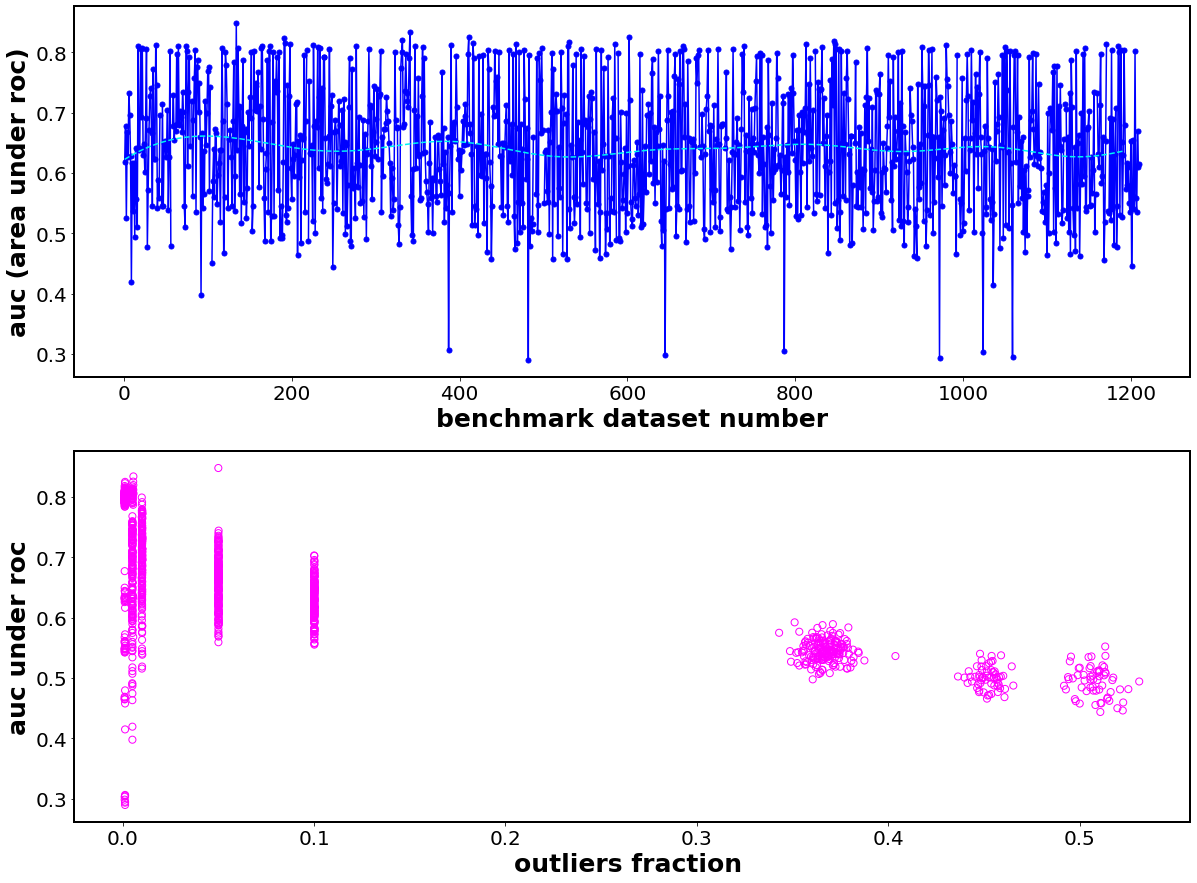

In [4]:
n_roc = len(roc_l)
x = list(range(1,n_roc+1))
# fig, ax = plt.subplots()
fig, axs = plt.subplots(2,1)
fig.set_size_inches((20,15))
labelsize = 25
plt.rcParams["font.family"] = "Arial"

ax0,ax1 = axs

ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)

regr = make_pipeline(StandardScaler(), SVR(gamma=2.7,C=42.7, epsilon=0.1))

u_roc_l = [x for x in roc_l if x is not None]
n_roc = len(u_roc_l)
ux = list(range(1,n_roc+1))
ux_ary = np.array(ux,np.float)
roc_ary = np.array(u_roc_l,np.float)
regr.fit(np.reshape(ux_ary,(-1,1)),roc_ary)

ax0.set_xlabel("benchmark dataset number", fontdict={"size":labelsize,"weight":"bold"})
ax0.set_ylabel("auc (area under roc)", fontdict={"size":labelsize,"weight":"bold"})
ax0.plot(x,roc_l,linestyle='-',marker='.',markersize=10,color="#0000ff")
ax0.plot(ux_ary,regr.predict(np.reshape(ux_ary,(-1,1))),linestyle='--',color="#00f3f4")

# outliers_fraction_l = sorted(outliers_fraction_l)
ax1.set_xlabel("outliers fraction ", fontdict={"size":labelsize,"weight":"bold"})
ax1.set_ylabel("auc under roc", fontdict={"size":labelsize,"weight":"bold"})
ax1.scatter(outliers_fraction_l,roc_l,marker='o',s=50,c='',edgecolors="#ff00ff")

bwidth = 2
b_l = ["top","bottom","left","right"]
for b in b_l:
    ax0.spines[b].set_linewidth(bwidth)
    ax0.spines[b].set_color("black")
    ax1.spines[b].set_linewidth(bwidth)
    ax1.spines[b].set_color("black")  


In [5]:
plt.show()

 >4. 结论
 > 可以看出使用pca算法,auc值稳定在0.6到0.7之间，同时还可以看出，在离群点比较少的情况下，pca算法能够成功检测出大部分离群点，而离群点接近一半的时候，则效果并不是非常理想

 # skin数据集离群点分析
 > 1. 数据说明
 > 展示benchmark的格式

In [6]:
benchmarks_path = "dataset\skin\\benchmarks"

benchmark_l = os.listdir(benchmarks_path)
benchmark_path = os.path.join(benchmarks_path,benchmark_l[0])
b_df = pd.read_csv(benchmark_path)
b_df

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_206237,skin,binary,2,0.336319,nominal,1.749794,-0.375490,-0.429661
1,skin_point_025203,skin,binary,1,0.658900,anomaly,0.272016,0.308514,1.306781
2,skin_point_078054,skin,binary,2,0.322800,nominal,1.862233,-0.242026,-0.539912
3,skin_point_026435,skin,binary,1,0.109419,anomaly,0.432644,0.558759,1.499719
4,skin_point_006216,skin,binary,1,0.647684,anomaly,-0.595375,-0.508954,0.424779
...,...,...,...,...,...,...,...,...,...
5995,skin_point_170257,skin,binary,2,0.340603,nominal,-0.466872,0.592125,-0.925788
5996,skin_point_228465,skin,binary,2,0.340603,nominal,-0.707814,0.825687,0.783092
5997,skin_point_193220,skin,binary,2,0.340603,nominal,1.862233,1.709887,1.031155
5998,skin_point_172942,skin,binary,2,0.339196,nominal,1.203659,0.642174,-0.691506


 >2. 模型建立
 >直接在benchmark上测试，使用random state进行分割，60%用于训练，40%用于测试

In [7]:
roc_l = []
outliers_fraction_l = []

for b in benchmark_l:
    benchmark_path = os.path.join(benchmarks_path,b)
    b_df = pd.read_csv(benchmark_path)
    b_df.sort_values(by="point.id",ascending=True,inplace=True)
    b_df.reset_index(inplace=True)

# > 取出属性
    attri_df = b_df.iloc[:,4:]
    attri_df.drop(["ground.truth"],axis=1,inplace=True)

# > 取出label
    label_df = b_df.iloc[:,6]

    label_df.loc[label_df == "nominal"] = 0
    label_df.loc[label_df == "anomaly"] = 1

    X = attri_df.to_numpy(np.float)
    y = label_df.to_numpy(np.float)

    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_fraction_l.append(outliers_fraction)

    random_state = np.random.RandomState(42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.43,
                                                            random_state=random_state)

    # pre_train = PCA(n_components=13,n_selected_components=10,svd_solver="full",contamination=0.4,random_state=random_state)
    pre_train = PCA(n_components=5,n_selected_components=3,svd_solver="full", contamination=0.4,random_state=random_state)

    try:
        trained = pre_train.fit(X_train,y_train)
        prediction = trained.predict(X_test)
        
        
        roc = roc_auc_score(y_test,prediction)
        roc_l.append(roc)
    except:
        roc_l.append(None)


 >3. 可视化展示

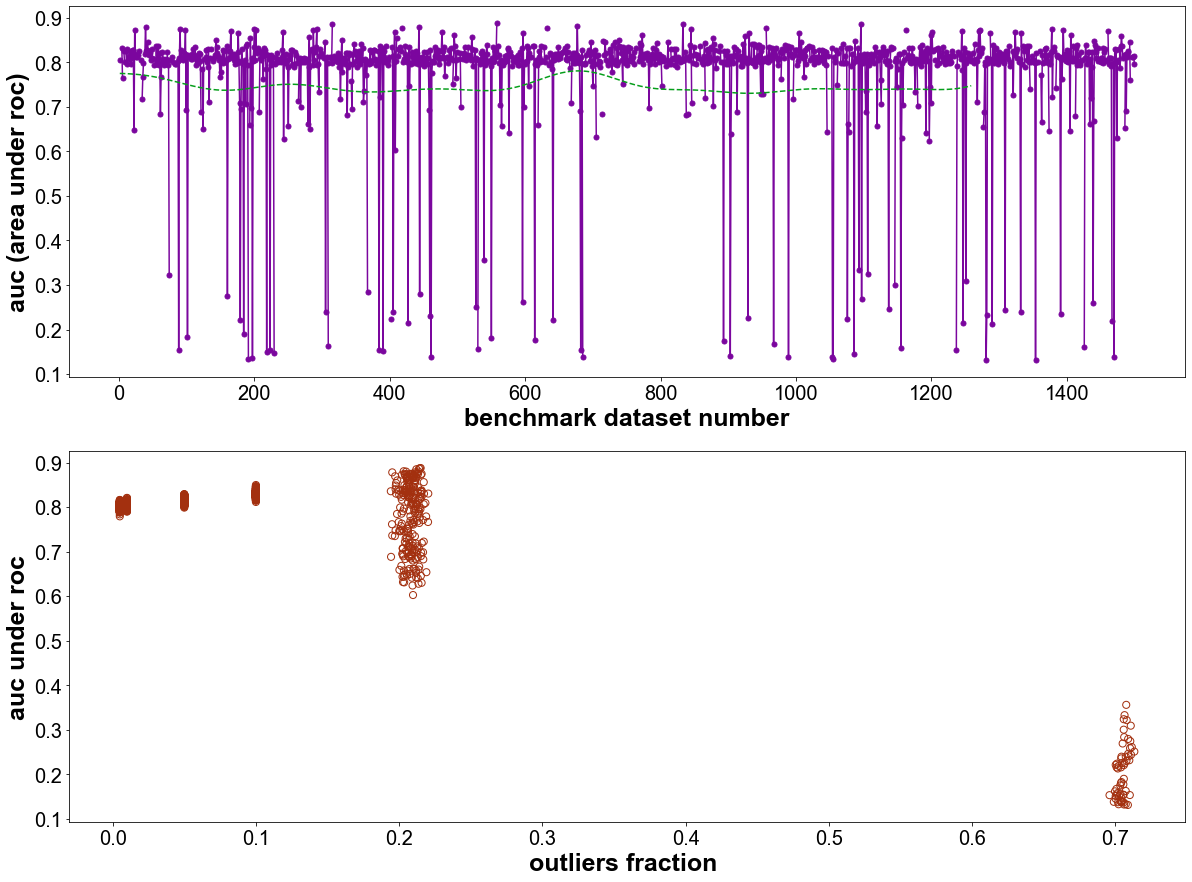

In [8]:
n_roc = len(roc_l)
x = list(range(1,n_roc+1))
# fig, ax = plt.subplots()
fig, axs = plt.subplots(2,1)
fig.set_size_inches((20,15))
labelsize = 25
plt.rcParams["font.family"] = "Arial"

ax0,ax1 = axs

ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)

regr = make_pipeline(StandardScaler(), SVR(gamma=5.7,C=3.7, epsilon=0.1))

u_roc_l = [x for x in roc_l if x is not None]
n_roc = len(u_roc_l)
ux = list(range(1,n_roc+1))
ux_ary = np.array(ux,np.float)
roc_ary = np.array(u_roc_l,np.float)
regr.fit(np.reshape(ux_ary,(-1,1)),roc_ary)

ax0.set_xlabel("benchmark dataset number", fontdict={"size":labelsize,"weight":"bold"})
ax0.set_ylabel("auc (area under roc)", fontdict={"size":labelsize,"weight":"bold"})
ax0.plot(x,roc_l,linestyle='-',marker='.',markersize=10,color="#7b069e")
ax0.plot(ux_ary,regr.predict(np.reshape(ux_ary,(-1,1))),linestyle='--',color="#069e1b")
# outliers_fraction_l = sorted(outliers_fraction_l)
ax1.set_xlabel("outliers fraction ", fontdict={"size":labelsize,"weight":"bold"})
ax1.set_ylabel("auc under roc", fontdict={"size":labelsize,"weight":"bold"})
ax1.scatter(outliers_fraction_l,roc_l,marker='o',s=50,c='', edgecolors="#a3300f")


In [9]:
bwidth = 2
b_l = ["top","bottom","left","right"]
for b in b_l:
    ax0.spines[b].set_linewidth(bwidth)
    ax0.spines[b].set_color("black")
    ax1.spines[b].set_linewidth(bwidth)
    ax1.spines[b].set_color("black")  


In [10]:
plt.show()

 >4. 结论
 > 可以看出使用pca算法,auc值稳定在0.7到0.8之间，同时还可以看出，在离群点比较少的情况下，比如0.1到0.2间，pca算法能够成功检测出大部分离群点，而离群点较多，比如达到0.7左右的，则效果并不# > 是非常理想